In [32]:
from os.path import join
from os import mkdir
import geopandas as gpd
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from tqdm import tqdm
import json
from distutils.dir_util import copy_tree
import shutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, SCORERS
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from random import random
from sklearn.model_selection import ShuffleSplit, KFold

In [33]:
dataset_folder = "Original"
data_id = "INDEX"
fold_col = "INDEX_FOLDS"
target_col = "TARGET"
fs_method = "CFS"
meshblock_filename = "POA_2016_AUST.shp"
adj_matrix_filename = "queen_matrix.csv"
meshblocks_id = "POA_CODE"
dec = 0.05
output_path =  "/exp/tpinho/Datasets/Australia_Election_2019"
data_path = f"/exp/tpinho/Datasets/Australia_Election_2019/{dataset_folder}/data.csv"
adj_matrix_path = f"/exp/tpinho/Datasets/Australia_Election_2019/{dataset_folder}/{adj_matrix_filename}"
meshblock_path = f"/exp/tpinho/Datasets/Australia_Election_2019/{dataset_folder}/meshblocks/{meshblock_filename}"
meshblock_folder = f"/exp/tpinho/Datasets/Australia_Election_2019/{dataset_folder}/meshblocks/"

In [34]:
def _mkdir(dir, folder_name: str) -> None:
        """Creates a folder at current path"""
        # logger = logging.getLogger(self.logger_name)
        dir = join(dir, folder_name)
        try:
            mkdir(dir)
            # logger.info(f"Creating folder: /{folder_name}")
        except FileExistsError:
            pass
            # logger.info(f"Entering folder: /{folder_name}")
        return dir
            
def _get_neighbors(indexes, adj_matrix):
    """Return the 1-degree neighborhood from a given sub-graph formed by indexes"""
    area_matrix = adj_matrix.loc[indexes]
    neighbors = area_matrix.sum(axis=0) > 0
    neighbors = neighbors[neighbors].index
    neighbors = [n for n in neighbors if n not in indexes]
    return neighbors

In [40]:
data = pd.read_csv(data_path, index_col=data_id)
capitals = [idx for idx in data.index if any(c in data.loc[idx,"[GEO]_DIVISIONNM"] for c in ["Sydney", "Brisbane", "Adelaide", "Canberra", "Perth", "Melborne", "Solomon", "Clark"])]
print(data.loc[capitals, "INDEX_FOLDS"].value_counts())

SA     26
NSW    23
QLD    13
TAS    13
WA     11
ACT     5
Name: INDEX_FOLDS, dtype: int64


In [36]:
meshblock = gpd.read_file(meshblock_path)
meshblock.set_index(meshblocks_id, inplace=True)
adj_matrix = pd.read_csv(adj_matrix_path)
adj_matrix.set_index(adj_matrix.columns[0], inplace=True)
adj_matrix.columns = adj_matrix.index

In [37]:
meshblock["prob"] = [0] * len(meshblock)
for capital in tqdm(capitals):
    meshblock.loc[capital, "prob"] = 1
    n_computed = []
    hop = 0
    neighbors = [capital]
    while(neighbors):
        neighbors = _get_neighbors([capital] + n_computed, adj_matrix)
        prob = 1 * (1 - dec)**hop
        n_computed += neighbors
        hop += 1
        if meshblock.loc[neighbors, "prob"].mean() < prob:
            meshblock.loc[neighbors, "prob"] = prob

100%|██████████| 91/91 [02:23<00:00,  1.58s/it]


100%|██████████| 1/1 [01:41<00:00, 101.42s/it]


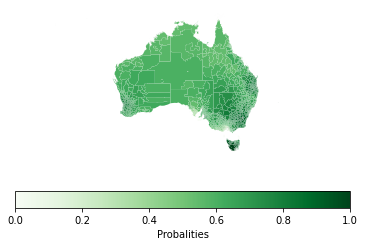

In [41]:
for threshold in tqdm([0.1]):
    output_folder = f"Australia_Election_2019_Sampled_dec{dec}_prob{threshold}"
    out_path = _mkdir(output_path, output_folder)
    copy_tree(meshblock_folder, join(out_path,"meshblocks"))
    shutil.copyfile(join(output_path, dataset_folder, "normd_matrix.csv"), join(out_path, "normd_matrix.csv"))
    shutil.copyfile(join(output_path, dataset_folder, "queen_matrix.csv"), join(out_path, "queen_matrix.csv"))
    meshblock["sampled"] = meshblock["prob"].apply(lambda p: 1 if p >= threshold else 0 )
    sampled_index = meshblock[meshblock["sampled"] == 1].index
    sampled_index = [idx for idx in sampled_index if idx in data.index]
    data_sampled = data.loc[sampled_index]
    data_sampled.to_csv(join(out_path, "data.csv"))
    meshblock.plot(column="prob",
                linewidth=.05, 
                edgecolor='white',
                legend=True, 
                cmap="Greens",
                vmin=0,
                vmax=1,
                legend_kwds={'label': "Probalities",
                             'orientation': "horizontal"},
              )
    plt.axis('off')
    plt.savefig(join(out_path, "sampled_map.jpg"))
    